# Faster R-CNN Model Training

***Converting the Dataset to TensorFlow Dataset***

In [2]:
# Imports 
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim

***Tensor Dataset***

In [3]:
# Define the COCO dataset class
class COCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        image_info = coco.loadImgs(img_id)[0]
        path = image_info['file_name']

        img = cv2.imread(os.path.join(self.image_dir, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(anns)
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        if boxes.size(0) > 0:  # Check if there are any boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Initialize dataset and dataloader
annotation_file = '../DataSetup/resized_annotations/annotations_train.json'
image_dir = '../DataSetup/resized_dataset/Train'
dataset = COCODataset(annotation_file, image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


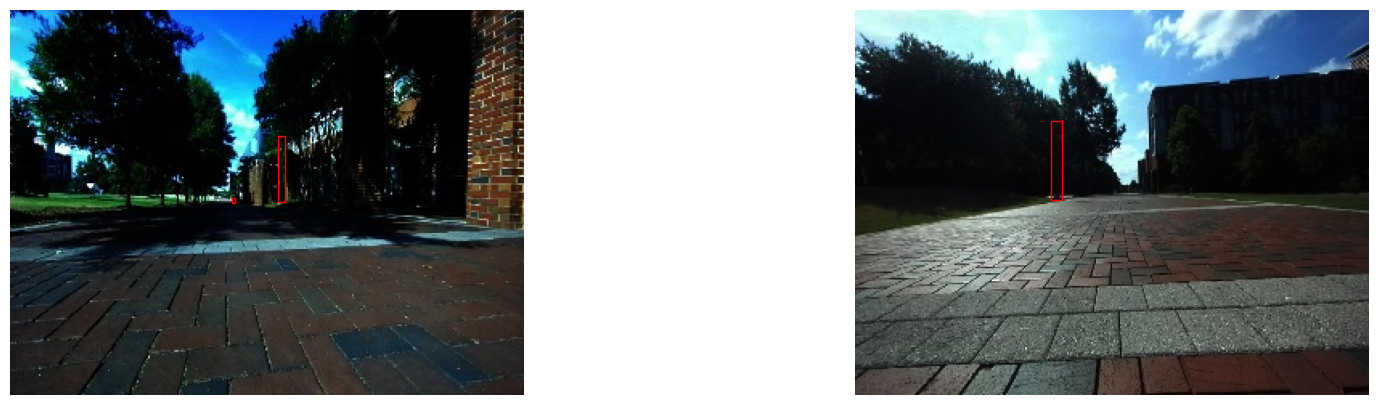

In [5]:
# Function to visualize a batch of images
def visualize_batch(images, targets):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, target) in enumerate(zip(images, targets)):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        axes[i].imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
            axes[i].add_patch(rect)
        axes[i].axis('off')
    plt.show()

# Get a batch of data
images, targets = next(iter(dataloader))

# Visualize the batch
visualize_batch(images, targets)

In [6]:
# Load a pre-trained model for classification and return only the features
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = len(dataset.coco.getCatIds()) + 1  # COCO class IDs + background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/home/turtle/anaconda3/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/turtle/anaconda3/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_epochs = 10
learning_rate = 0.005

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}, Loss: {losses.item()}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()
